In [6]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sciqaeval import config
import math

def load_data(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

def compute_averages(data, criteria):
    averages = {eval_type: {criterion: [] for criterion in criteria} for eval_type in ["original", "extreme", "subtle"]}
    for entry in data:
        eval_type = entry["eval_type"]
        quality = entry["quality"]
        rating = entry["synthesis_evaluation_rating"]
        if quality in averages[eval_type]:
            if not math.isnan(rating):
                averages[eval_type][quality].append(float(rating))
    for eval_type in averages:
        for quality in averages[eval_type]:
            if averages[eval_type][quality]:
                averages[eval_type][quality] = sum(averages[eval_type][quality])/len(averages[eval_type][quality])
            else:
                averages[eval_type][quality] = 0
    return averages

In [8]:
criteria = config.criteria

dataset1 = load_data("dataset/BioASQ/BioASQ_test_meta-llama-3.1-70b-instruct_refactored_dataset.json")
dataset2 = load_data("dataset/ORKG-Synthesis/llm4syn_test_meta-llama-3.1-70b-instruct_refactored_dataset.json")
averages1 = compute_averages(dataset1, criteria)
averages2 = compute_averages(dataset2, criteria)
averages = [[averages1, averages2, 'Vanilla LLaMA-3.1-70B', 'gainsboro']]

dataset1 = load_data("dataset/BioASQ/BioASQ_test_mistral-large-instruct_refactored_dataset.json")
dataset2 = load_data("dataset/ORKG-Synthesis/llm4syn_test_mistral-large-instruct_refactored_dataset.json")
averages1 = compute_averages(dataset1, criteria)
averages2 = compute_averages(dataset2, criteria)
averages += [[averages1, averages2, 'Vanilla Mistral-Large', 'gainsboro']]

dataset1 = load_data("dataset/BioASQ/BioASQ_test_qwen2.5-72b-instruct_refactored_dataset.json")
dataset2 = load_data("dataset/ORKG-Synthesis/llm4syn_test_qwen2.5-72b-instruct_refactored_dataset.json")
averages1 = compute_averages(dataset1, criteria)
averages2 = compute_averages(dataset2, criteria)
averages += [[averages1, averages2, 'Vanilla Qwen2.5-72B', 'gainsboro']]

dataset1 = load_data("dataset/BioASQ/BioASQ-test-refactored-dataset.json")
dataset2 = load_data("dataset/ORKG-Synthesis/llm4syn-test-refactored-dataset.json")
averages1 = compute_averages(dataset1, criteria)
averages2 = compute_averages(dataset2, criteria)
averages += [[averages1, averages2, 'Vanilla LLaMA-3.1-8B', 'teal']]

dataset1 = load_data("assets/sft-bioasq-org-test.json")
dataset2 = load_data("assets/sft-orkg-synthesis-org-test.json")
averages1 = compute_averages(dataset1, criteria)
averages2 = compute_averages(dataset2, criteria)
averages += [[averages1, averages2, 'SFT (benign)', 'orange']]

dataset1 = load_data("assets/rlhf-bioasq-adv-test.json")
dataset2 = load_data("assets/rlhf-orkg-synthesis-adv-test.json")
averages1 = compute_averages(dataset1, criteria)
averages2 = compute_averages(dataset2, criteria)
averages += [[averages1, averages2, 'SFT (benign) + RL (adversarial)', 'tomato']]

dataset1 = load_data("assets/rlhf-bioasq-adv-org-test.json")
dataset2 = load_data("assets/rlhf-orkg-synthesis-adv-org-test.json")
averages1 = compute_averages(dataset1, criteria)
averages2 = compute_averages(dataset2, criteria)
averages += [[averages1, averages2, 'SFT (benign) + RL (benign + adversarial)', 'yellowgreen']]

In [11]:
def plot_results(averages, criteria, dataset_name1, dataset_name2, font_size=12):
    criteria_abbreviations = {
        "Coherence": "Cohr",
        "Cohesion": "Cohs",
        "Completeness": "Comp",
        "Conciseness": "Conc",
        "Correctness": "Corr",
        "Informativeness": "Info",
        "Integration": "Integ",
        "Readability": "Read",
        "Relevancy": "Relv"
    }
    fig, axes = plt.subplots(2, 3, figsize=(10, 5), sharey=True)    
    eval_types = ["original", "extreme", "subtle"]
    dataset_names = [dataset_name1, dataset_name2]
    legend_handles = []  
    legend_labels = []  
    for average in averages:
        avg = [average[0], average[1]] 
        title = average[2]
        color = average[3]
        
        markers = {'Vanilla LLaMA-3.1-70B':'*', 'Vanilla Mistral-Large':'+', 'Vanilla Qwen2.5-72B':'^'}

        marker= markers.get(title, 'o')
        for i, dataset in enumerate(avg):
            for j, eval_type in enumerate(eval_types):
                ax = axes[i, j]  
                line, = ax.plot(criteria, 
                                [dataset[eval_type][c] for c in criteria], 
                                marker=marker, 
                                linestyle='-', 
                                linewidth=0.9,
                                color=color,
                                markersize=font_size-5)
                ax.set_title(f"{dataset_names[i]} - {eval_type.capitalize() if eval_type!='original' else 'Benign'}", 
                             fontsize=font_size)
                ax.tick_params(axis='both', labelsize=font_size - 3)
                ax.grid(True, linestyle="--", alpha=0.15)
                # ax.set_yticks([1, 2, 3, 4, 5])
                ax.set_xticklabels([criteria_abbreviations[crit] for crit in criteria], rotation=0)
        legend_handles.append(line)
        legend_labels.append(title)
    
    fig.legend(legend_handles, legend_labels, loc="upper center", ncol=7, fontsize=font_size-3, bbox_to_anchor=(0.5, 0.97))
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("images/results_plot.pdf", format="pdf", bbox_inches="tight")
    plt.savefig("images/results_plot.png", format="png", dpi=300, bbox_inches="tight")
    plt.show()

/tmp/ipykernel_803013/3035001349.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([criteria_abbreviations[crit] for crit in criteria], rotation=0)


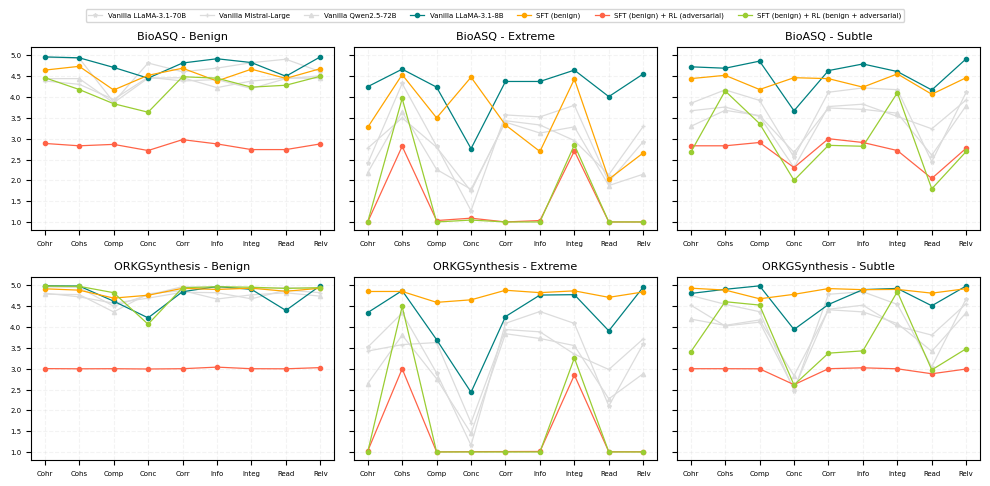

In [12]:
plot_results(averages, criteria, "BioASQ", "ORKGSynthesis", font_size=8)